Autoencoder LSTM


Detección de Anomalías No Supervisada: Los autoencoders son modelos no supervisados. Esto significa que aprenden a partir de datos "normales" sin necesidad de tener ejemplos pre-etiquetados de "huachicoleo".

 Esto es útil porque obtener datos etiquetados de eventos de huachicoleo puede ser difícil. El modelo aprende qué es el comportamiento típico de la tubería y cualquier desviación significativa se considera una anomalía.

Manejo de Datos Secuenciales (Series de Tiempo): Los datos de las tuberías (flujo, presión, RPM de la bomba, nivel del tanque, potencia) son datos de series de tiempo, lo que significa que el orden y la secuencia de los datos son importantes. Las redes LSTM (Long Short-Term Memory) son un tipo de red neuronal recurrente que es muy efectiva para modelar secuencias y capturar dependencias temporales. Un autoencoder basado en LSTM puede aprender los patrones temporales normales en los datos de la tubería.

Identificación de Desviaciones Complejas: Los eventos de huachicoleo pueden manifestarse como cambios sutiles o complejos en múltiples variables a lo largo del tiempo que podrían no ser obvios con métodos de detección de anomalías más simples. Un autoencoder LSTM puede aprender representaciones complejas de datos normales y la incapacidad de reconstruir con precisión una secuencia de datos anómalos (que representa un evento de huachicoleo) resulta en un alto error de reconstrucción.

Adaptabilidad: Una vez entrenado en datos normales, el autoencoder puede detectar nuevos tipos de anomalías que no se vieron durante el entrenamiento, siempre y cuando esas anomalías resulten en un patrón que el modelo no puede reconstruir bien.

Reducción de Dimensionalidad (implícita): Aunque no es el objetivo principal, la capa codificadora del autoencoder comprime los datos de alta dimensión (múltiples características a lo largo del tiempo) en una representación de menor dimensión. Esto puede ayudar al modelo a aprender las características más importantes de los datos normales.

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


#Cargar dataset
df = pd.read_csv("rebombeo_huachicoleo.csv", parse_dates=["timestamp"])


#Seleccionar features y normalizar
features = ["flow", "pressure", "pump_rpm", "tank_level", "power"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])


#Crear ventanas para entrenamiento
def create_windows(data, window_size, step=1):
    X = []
    for start in range(0, len(data) - window_size + 1, step):
        X.append(data[start:start+window_size])
    return np.array(X)


WINDOW = 30 # tamaño de la ventana (30 minutos)
STEP = 5 # desplazamiento de la ventana
X = create_windows(scaled_data, WINDOW, step=STEP)


# Ajustar etiquetas para ventanas (si alguna muestra en la ventana es anomalía => 1)
labels = df["label"].values
window_labels = []
for start in range(0, len(labels) - WINDOW + 1, STEP):
    window_labels.append(int(labels[start:start+WINDOW].max()))
window_labels = np.array(window_labels)


# Dividir en train (solo normales), val, test
normal_idx = np.where(window_labels == 0)[0]
anomaly_idx = np.where(window_labels == 1)[0]


n_train = int(0.6 * len(normal_idx))
n_val = int(0.2 * len(normal_idx))


X_train = X[normal_idx[:n_train]]
X_val = X[normal_idx[n_train:n_train+n_val]]
X_test = X[normal_idx[n_train+n_val:]]
X_test = np.concatenate([X_test, X[anomaly_idx]]) # incluir anomalías en test


labels_test = np.concatenate([np.zeros(len(X[normal_idx[n_train+n_val:]])), np.ones(len(anomaly_idx))])


# --- 4. Definir modelo LSTM Autoencoder
timesteps = X_train.shape[1]
n_features = X_train.shape[2]


input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation="tanh", return_sequences=True)(input_layer)
encoded = LSTM(32, activation="tanh")(encoded)


decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation="tanh", return_sequences=True)(decoded)
decoded = LSTM(64, activation="tanh", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)


autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")


# --- 5. Entrenar

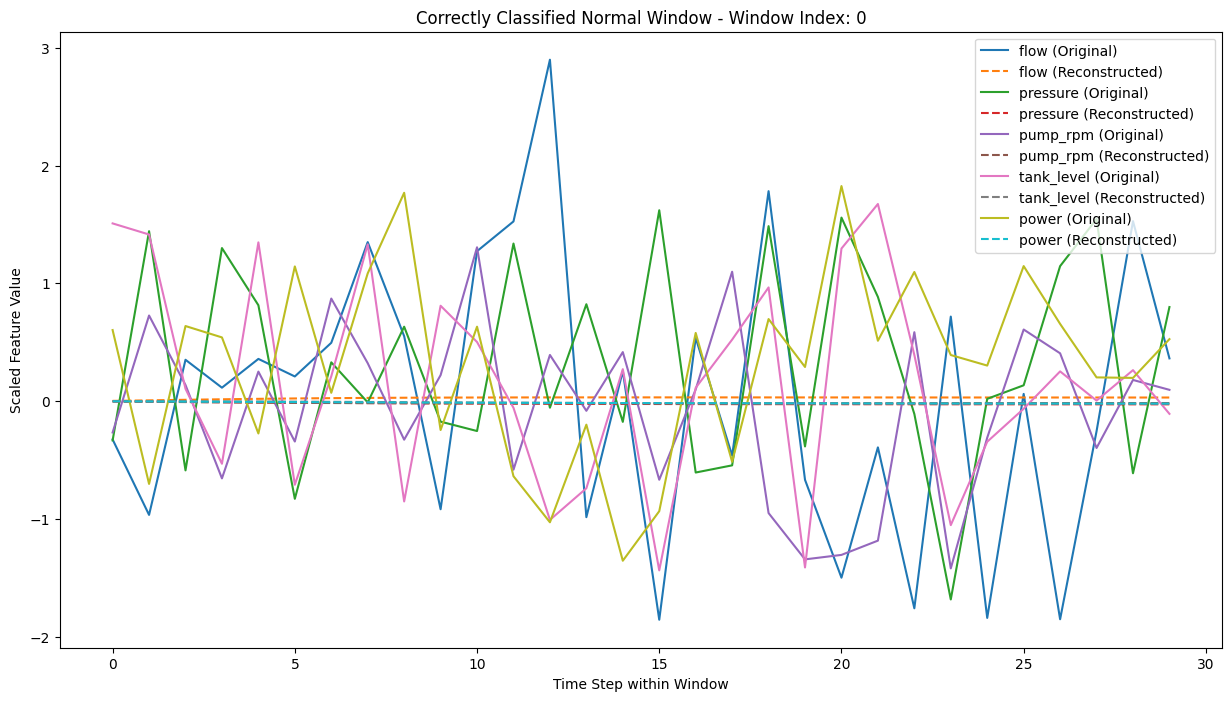

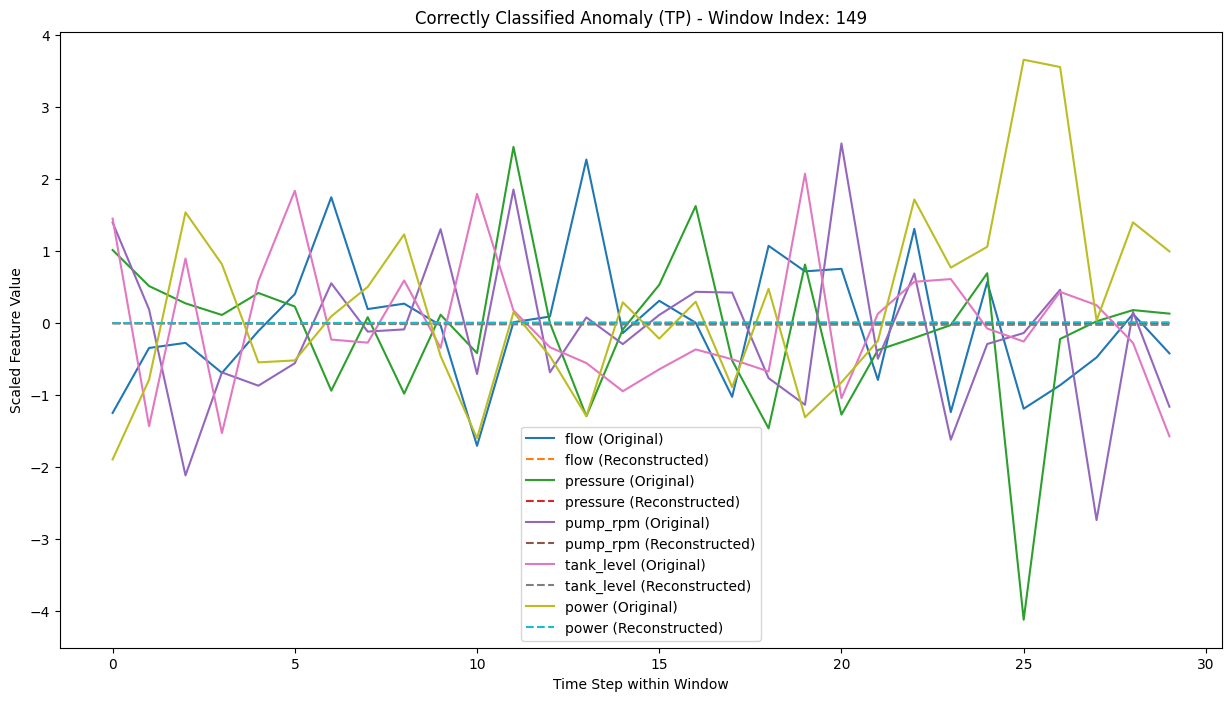

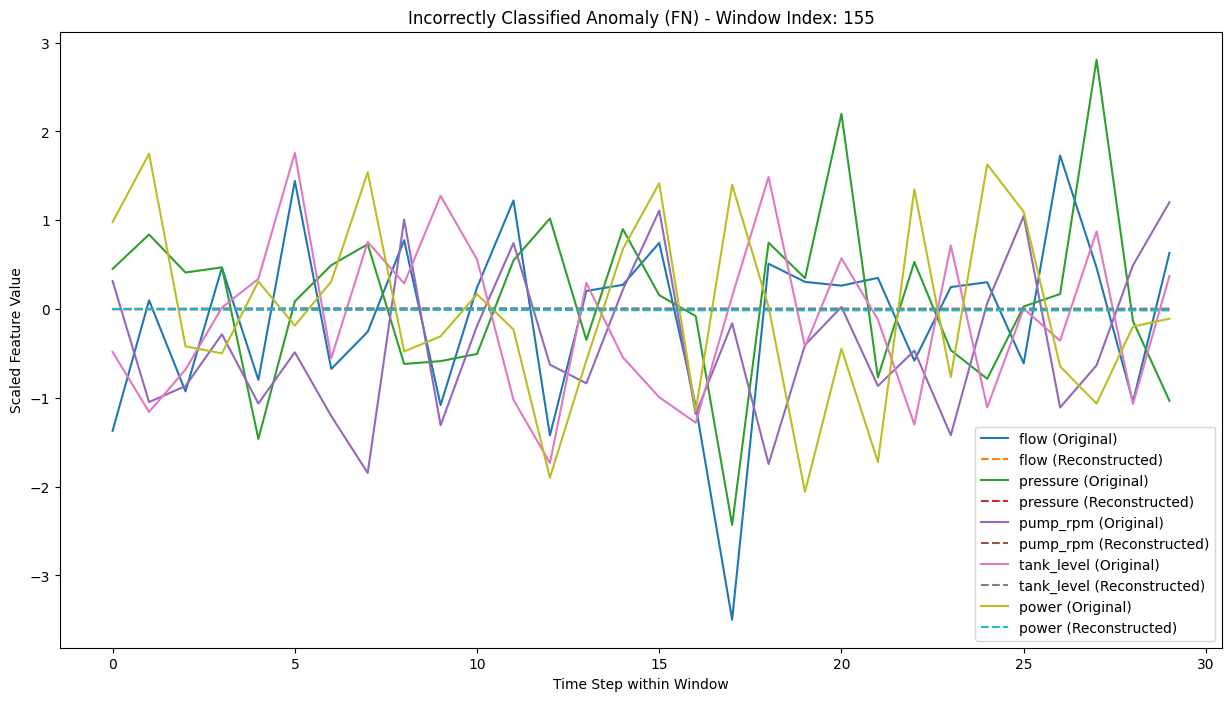

In [9]:
# Select example windows for visualization
# Correctly classified normal: Find an index where labels_test is 0 and predicted_labels is 0
normal_correct_idx = np.where((labels_test == 0) & (predicted_labels == 0))[0][0]

# Correctly classified anomalous (True Positive): Find an index where labels_test is 1 and predicted_labels is 1
anomaly_correct_idx = np.where((labels_test == 1) & (predicted_labels == 1))[0][0]

# Incorrectly classified anomalous (False Negative): Find an index where labels_test is 1 and predicted_labels == 0
anomaly_incorrect_idx = np.where((labels_test == 1) & (predicted_labels == 0))[0][0]

example_indices = [normal_correct_idx, anomaly_correct_idx, anomaly_incorrect_idx]
example_titles = ["Correctly Classified Normal Window", "Correctly Classified Anomaly (TP)", "Incorrectly Classified Anomaly (FN)"]

# Visualize original vs. reconstructed data for selected windows
for i, idx in enumerate(example_indices):
    plt.figure(figsize=(15, 8))
    original_data = X_test[idx]
    reconstructed_data = X_test_pred[idx]

    for feature_idx, feature_name in enumerate(features):
        plt.plot(original_data[:, feature_idx], label=f'{feature_name} (Original)', linestyle='-')
        plt.plot(reconstructed_data[:, feature_idx], label=f'{feature_name} (Reconstructed)', linestyle='--')

    plt.title(f"{example_titles[i]} - Window Index: {idx}")
    plt.xlabel("Time Step within Window")
    plt.ylabel("Scaled Feature Value")
    plt.legend()
    plt.show()

## Resumen:



* El umbral de detección de anomalías se estableció en aproximadamente 0.9521, basado en el percentil 95 de los errores de reconstrucción para datos normales.
* El modelo logró una Precisión de 0.9626, una Exhaustividad (Recall) de 0.8142 y una Puntuación F1 de 0.8822.
* La matriz de confusión mostró 141 Verdaderos Negativos, 8 Falsos Positivos, 47 Falsos Negativos y 206 Verdaderos Positivos.
* Las visualizaciones de los errores de reconstrucción a lo largo del tiempo mostraron claramente que los puntos de datos anómalos generalmente tienen errores de reconstrucción más altos que los puntos de datos normales, superando el umbral establecido.
* Las visualizaciones que comparan los datos originales y reconstruidos para ventanas seleccionadas ilustraron que el autoencoder reconstruye eficazmente los datos normales pero tiene dificultades para reconstruir datos anómalos, lo que lleva a errores de reconstrucción más grandes en las ventanas anómalas.
* La visualización de una anomalía clasificada incorrectamente (Falso Negativo) indicó que, aunque hubo cierta desviación en la reconstrucción, no fue lo suficientemente significativa como para cruzar el umbral de anomalía.



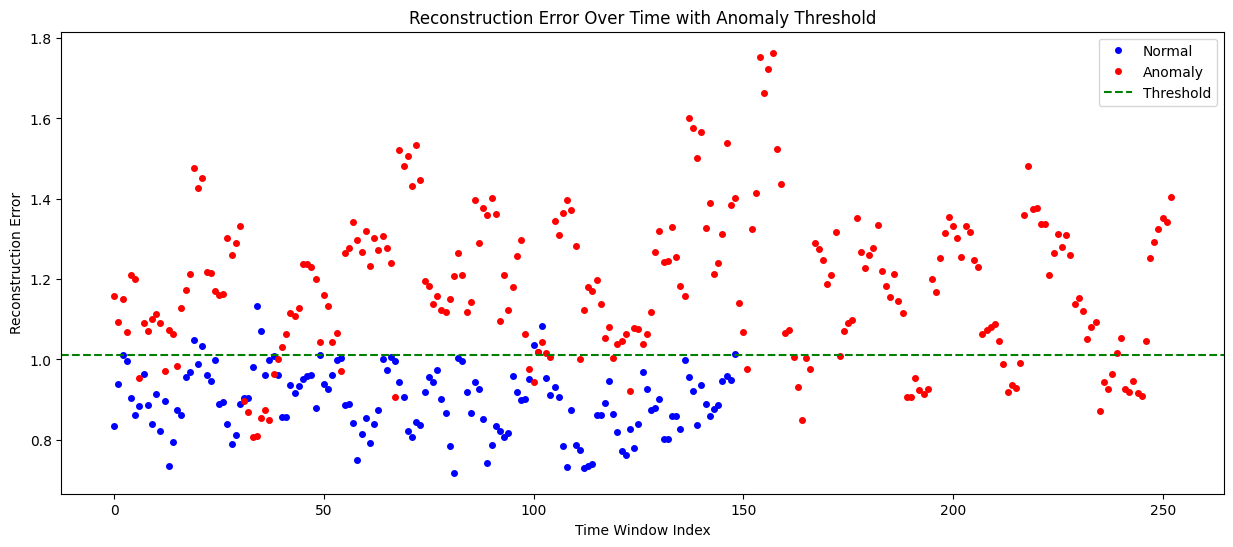

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(reconstruction_errors[labels_test == 0], 'o', color='blue', markersize=4, label='Normal')
plt.plot(reconstruction_errors[labels_test == 1], 'o', color='red', markersize=4, label='Anomaly')
plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Over Time with Anomaly Threshold")
plt.xlabel("Time Window Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

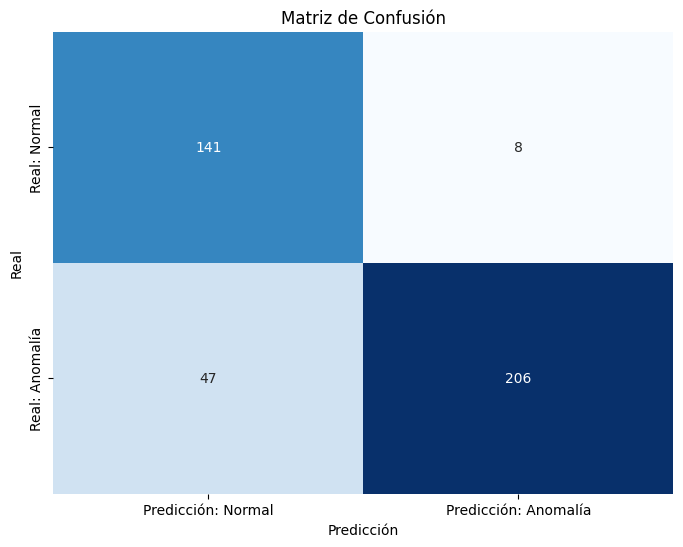

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming 'labels_test' and 'predicted_labels' are already defined from the evaluation step
# If not, you would need to run the evaluation cell first to get these variables.

# Calculate the confusion matrix
cm = confusion_matrix(labels_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicción: Normal', 'Predicción: Anomalía'],
            yticklabels=['Real: Normal', 'Real: Anomalía'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

## Matriz de Confusión

Una Matriz de Confusión es una tabla que se utiliza para describir el rendimiento de un modelo de clasificación en un conjunto de datos donde se conocen los valores verdaderos. Compara las etiquetas verdaderas con las etiquetas predichas por el modelo.

Aquí tienes un diagrama básico de una matriz de confusión para un problema de clasificación binaria (dos clases, por ejemplo, "Normal" y "Anomalía"):

|                 | **Predicción: Normal** | **Predicción: Anomalía** |
| :-------------- | :--------------------- | :----------------------- |
| **Real: Normal**    | Verdaderos Negativos (TN) | Falsos Positivos (FP)    |
| **Real: Anomalía** | Falsos Negativos (FN)     | Verdaderos Positivos (TP) |

**Explicación de los términos:**

*   **Verdaderos Positivos (TP):** Casos en los que el modelo predijo correctamente la clase positiva (Anomalía) y la etiqueta verdadera era positiva (Anomalía).
*   **Verdaderos Negativos (TN):** Casos en los que el modelo predijo correctamente la clase negativa (Normal) y la etiqueta verdadera era negativa (Normal).
*   **Falsos Positivos (FP):** Casos en los que el modelo predijo incorrectamente la clase positiva (Anomalía) cuando la etiqueta verdadera era negativa (Normal). Esto también se conoce como un "Error de Tipo I".
*   **Falsos Negativos (FN):** Casos en los que el modelo predijo incorrectamente la clase negativa (Normal) cuando la etiqueta verdadera era positiva (Anomalía). Esto también se conoce como un "Error de Tipo II".

En el contexto de tu detección de anomalías:

*   **TP:** Ventanas que son realmente anomalías y el modelo las identificó como anomalías.
*   **TN:** Ventanas que son realmente normales y el modelo las identificó como normales.
*   **FP:** Ventanas que son realmente normales pero el modelo las identificó erróneamente como anomalías.
*   **FN:** Ventanas que son realmente anomalías pero el modelo las identificó erróneamente como normales.


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.9384 - val_loss: 0.9407
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.9278 - val_loss: 0.9333
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.9182 - val_loss: 0.9298
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9138 - val_loss: 0.9291
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9164 - val_loss: 0.9277
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.9123 - val_loss: 0.9250
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.9103 - val_loss: 0.9222
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.9037 - val_loss: 0.9196
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.9049 - val_loss: 0.9171
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.9059 - val_loss: 0.9151
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.8968 - val_loss: 0.9131
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

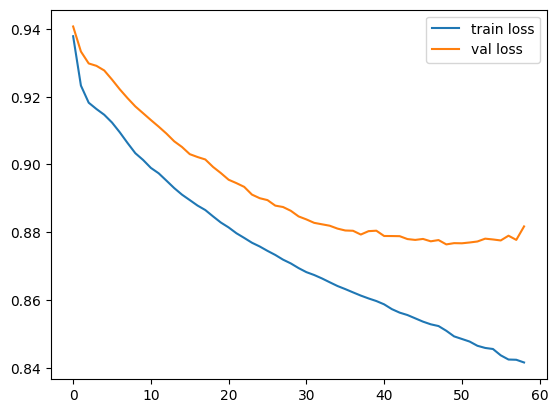

In [12]:
# Entrenar
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=32,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Calcular errores de reconstrucción y umbral


Calcular el error de reconstrucción para cada punto de datos (o ventana) en el conjunto de prueba. Determinar un umbral adecuado para la detección de anomalías basado en la distribución de errores de reconstrucción para datos normales.



**Razonamiento**:
El primer paso es calcular el error de reconstrucción para el conjunto de prueba prediciendo la salida del autoencoder y luego calculando el MSE. Después de eso, necesitamos aislar los errores de reconstrucción para los puntos de datos normales para determinar un umbral adecuado para la detección de anomalías.




In [15]:
# Predict the reconstruction of the test set
X_test_pred = autoencoder.predict(X_test)

# Calculate the reconstruction error (MSE) for each window in the test set
reconstruction_errors = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

# Separate reconstruction errors for normal and anomalous data
normal_reconstruction_errors = reconstruction_errors[labels_test == 0]
anomaly_reconstruction_errors = reconstruction_errors[labels_test == 1]

# Determine a threshold for anomaly detection using a percentile of normal reconstruction errors
threshold = np.percentile(normal_reconstruction_errors, 95)

# Calculate predicted labels based on the threshold
predicted_labels = (reconstruction_errors > threshold).astype(int)

# Print the calculated threshold
print(f"Anomaly detection threshold (95th percentile of normal errors): {threshold}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Anomaly detection threshold (95th percentile of normal errors): 0.9557491753255177
